## DATABOOTCAMP PROJECT : CREDIT RISK MODELLING

#### WHAT IS CREDIT RISK AND WHY IS IT IMPORTANT?
When giving out a loan, a creditor provides credit to a borrower based on the trust that borrower will repay the lender. when someone fails to repay a loan,it is said to be default.The possiblity that someone who has borrowed money will default is known as Credit Risk.

Lenders inability or failure to  estimate borrowers probablity is critical as defaults on borrowed loans can have serious consequences for lenders and the overall society.In general, lending to borrowers with a high probability of default (sub-prime borrowers) is one of the main reasons for serious financial crisis such as the global financial crisis in 2008.It was the most serious financial crisis since the times of the Great Depression in the 1930s.The main factor that led to the 2008 financial crisis was high default rates of subprime home mortgages. Many big banks like Lehmam Brothers and Bear Stearns went bakrupt.Therefore, credit risk analysis is an important component of today's financial system.
#### Project Focus
It is important to be able to estimate credit risk of each borrower as precisely as possible.Hence, our project focuses on modelling three different classification models namely Logistic Regression, Naive Bayes, and Decision Tree.Our goal is to determine whether a borrower will default or not on the basis of several factors such as income, age, location and interest rate. We will also compare the three models to determine the best model on the basis of AUC score and cross validation score.

#### Downloading Packages

In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

#### Importing Data into dataframe 
The dataset contains all available data for more than 800000 consumer loans issued from 2007 to 2015 by lending club a large U.S. peer to peer lending company. we have downloaded data from kaggle https://www.kaggle.com/wendykan/lending-club-loan-data

In [2]:
loan = pd.read_csv(r"loan_data_2007_2014.csv")


### GENERAL DATA PREPROCESSING

In [3]:
#First lets get the information about data
#loan.info()

#### From the above loan info we can see that there are few object variable that we need as numeric like emp_length,term. Hence we change them to numeric

In [4]:
loan['emp_length'].unique()

array(['10+ years', '< 1 year', '1 year', '3 years', '8 years', '9 years',
       '4 years', '5 years', '6 years', '2 years', '7 years', nan],
      dtype=object)

In [5]:
# Removing years from emp_lenght
loan['emp_length'] = loan['emp_length'].str.replace('\+ years', '')
loan['emp_length'] = loan['emp_length'].str.replace('< 1 year', str(0))
loan['emp_length'] = loan['emp_length'].str.replace('n/a',  str(0))
loan['emp_length'] = loan['emp_length'].str.replace(' years', '')
loan['emp_length'] = loan['emp_length'].str.replace(' year', '')
#changing emp_length to numeric
loan['emp_length'] = pd.to_numeric(loan['emp_length'])
loan['emp_length'].head()


0    10.0
1     0.0
2    10.0
3    10.0
4     1.0
Name: emp_length, dtype: float64

In [6]:
# simlilarly changing term variable to numeric
loan['term'] = loan['term'].str.replace('months','')
loan['term'] = pd.to_numeric(loan['term'])
#loan['term'].head()

#### Now changing few attributes like 'earliest_cr_line' and 'issue_d' to datetime datatype

In [7]:
##Converting to datetime format
loan['earliest_cr_line'] = pd.to_datetime(loan['earliest_cr_line'], format = '%b-%y')
loan['earliest_cr_line'].head(1)


0   1985-01-01
Name: earliest_cr_line, dtype: datetime64[ns]

In [8]:
## We take the reference date and calulate the time since earliest credit line has passed in months
loan['month_diff_earliest_cr_line'] = round(pd.to_numeric((pd.to_datetime('2017-12-01') - loan['earliest_cr_line']) / np.timedelta64(1, 'M')))
# Dates from 1969 and before are not being converted well,they have become 2069 and similar
loan['month_diff_earliest_cr_line'].describe()

count    466256.000000
mean        239.482430
std          93.974829
min        -612.000000
25%         183.000000
50%         225.000000
75%         285.000000
max         587.000000
Name: month_diff_earliest_cr_line, dtype: float64

In [9]:
#There are 1169 such strange value.
loan.loc[loan['month_diff_earliest_cr_line'] < 0].count()
# Hence,we set the rows that had negative differences to the maximum value.
loan['month_diff_earliest_cr_line'][loan['month_diff_earliest_cr_line'] < 0] = loan['month_diff_earliest_cr_line'].max()

In [10]:
loan['issue_d']
##Converting to datetime format
loan['issue_d'] = pd.to_datetime(loan['issue_d'], format = '%b-%y')
#### We take the reference date and calulate the time since earliest credit line has passed in months
loan['month_diff_issue_d'] = round(pd.to_numeric((pd.to_datetime('2017-12-01') - loan['issue_d']) / np.timedelta64(1, 'M')))
loan['month_diff_issue_d'][loan['month_diff_issue_d'] < 0] = loan['month_diff_issue_d'].max()

 Next, we will generate dummy variable  for categorial variables

In [11]:
loan_dummies= [pd.get_dummies(loan['grade'], prefix = 'grade', prefix_sep = ':'),
               pd.get_dummies(loan['sub_grade'], prefix = 'sub_grade', prefix_sep = ':'),
               pd.get_dummies(loan['home_ownership'], prefix = 'home_ownership', prefix_sep = ':'),
               pd.get_dummies(loan['verification_status'], prefix = 'verification_status', prefix_sep = ':'),
               pd.get_dummies(loan['loan_status'], prefix = 'loan_status', prefix_sep = ':'),
               pd.get_dummies(loan['purpose'], prefix = 'purpose', prefix_sep = ':'),
               pd.get_dummies(loan['addr_state'], prefix = 'addr_state', prefix_sep = ':'),
               pd.get_dummies(loan['initial_list_status'], prefix = 'initial_list_status', prefix_sep = ':')]
loan_dummies = pd.concat(loan_dummies, axis = 1)
loan= pd.concat([loan, loan_dummies], axis = 1)


#### Checking for missing values and cleaning them
Total revolving high credit/ credit limit', is where one can access money until he/she has  borrowed up to the maximum amount,also known as your credit limit, so it makes sense that the missing values are equal to funded_amnt.

In [12]:
loan.isnull().sum()
loan['total_rev_hi_lim'].fillna(loan['funded_amnt'], inplace=True)

In [13]:
## Simililary we clean other attributes having missing values
loan['annual_inc'].fillna(loan['annual_inc'].mean(), inplace=True)
loan['month_diff_earliest_cr_line'].fillna(0, inplace=True)
loan['acc_now_delinq'].fillna(0, inplace=True)
loan['total_acc'].fillna(0, inplace=True)
loan['pub_rec'].fillna(0, inplace=True)
loan['open_acc'].fillna(0, inplace=True)
loan['inq_last_6mths'].fillna(0, inplace=True)
loan['delinq_2yrs'].fillna(0, inplace=True)
loan['emp_length'].fillna(0, inplace=True)

### DATA PREPARATION FOR MODEL
#### DEPENDENT VARIABLES,     GOOD/BAD LOAN DEFINITION

Dependent variable is what we are going to predict.We are interested in the borrowers and the respective loans on which they have defaulted or not.Loans that have defaulted will be called bad while those which did not are good loans. Therefore, its imperative for us to decribe what default is.we will create a new variable in the data set of a boolean or binary type.Zero will stand for default or bad loan while one for a good loan.

In [14]:
loan['loan_status'].unique()

array(['Fully Paid', 'Charged Off', 'Current', 'Default',
       'Late (31-120 days)', 'In Grace Period', 'Late (16-30 days)',
       'Does not meet the credit policy. Status:Fully Paid',
       'Does not meet the credit policy. Status:Charged Off'],
      dtype=object)

In [15]:
bad_loans = ['Charged Off', 'Default','Does not meet the credit policy. Status:Charged Off','Late (31-120 days)']
loan['good_bad'] = np.where(loan['loan_status'].isin(bad_loans), 0, 1)

The model must be very easy to understand and apply.Even people who have never heard of statistical analysis should be able to work with it.This is why the established practice is to categorize all the independent variables into the binary variables(dummy variables) or indicator variables.

#### Approach for constructing Independent Variable
Fine classing :- Create 10/20 bins/groups for a continuous independent variable and then calculates WOE and IV of the variable  Weight of Evidence :- To what extent an independent variable would predict a dependent variable  
                       WOE = ln(% non default events/% default events)    
Coarse classing :- We will bundle variables that have similar weight of evidence  
Information Value:- It calculates the prediction power of a feature

### Splitting Data

In [16]:
loan_data_inputs_train, loan_data_inputs_test, loan_data_targets_train, loan_data_targets_test = train_test_split(loan.drop('good_bad', axis = 1), loan[['good_bad']], test_size = 0.2, random_state = 50)

### <font color='green'>Note: It is required to re-run data processing step for test data so that we have same set of binary dummy variables as that of train data set. To do data processing for test data set, please un-comment test data code and comment train data code </font>

In [17]:
df_inputs = loan_data_inputs_train
df_targets = loan_data_targets_train

# df_inputs = loan_data_inputs_test
# df_targets = loan_data_targets_test


#### Please refer to the below link know more about WOE and Information Value
#### https://www.listendata.com/2015/03/weight-of-evidence-woe-and-information.html

In [18]:
def get_woe_discrete(df,column_name, good_bad_variable_df):
    df = pd.concat([df[column_name], good_bad_variable_df], axis = 1)
    df = pd.concat([df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].count(),
                    df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].mean()], axis = 1)
    df = df.iloc[:, [0, 1, 3]]
    df.columns = [df.columns.values[0], 'total_obs', 'prop_good']
    df['prop_total_obs'] = df['total_obs'] / df['total_obs'].sum()
    df['total_good'] = df['prop_good'] * df['total_obs']
    df['total_bad'] = (1 - df['prop_good']) * df['total_obs']
    df['prop_total_good'] = df['total_good'] / df['total_good'].sum()
    df['prop_total_bad'] = df['total_bad'] / df['total_bad'].sum()
    df['WoE'] = np.log(df['prop_total_good'] / df['prop_total_bad'])
    df = df.sort_values(['WoE'])
    df = df.reset_index(drop = True)
    df['IV'] = (df['prop_total_good'] - df['prop_total_bad']) * df['WoE']
    df['IV'] = df['IV'].sum()
    return df

In [19]:
def plot_by_woe(df_WoE, rotation_of_x_axis_labels = 0):
    x = np.array(df_WoE.iloc[:, 0].apply(str))
    y = df_WoE['WoE']
    plt.figure(figsize=(18, 6))
    plt.plot(x, y, marker = 'o', linestyle = '--', color = 'b')
    plt.xlabel(df_WoE.columns[0])
    plt.ylabel('Weight of Evidence')
    plt.title(str('Weight of Evidence by ' + df_WoE.columns[0]))
    plt.xticks(rotation = rotation_of_x_axis_labels)

##### Rules we followed for categorizing variable by WOE:-  
1. Each category (bin) should have at least 5% of the observations. 
2. Each category (bin) should be non-zero for both non-events and events.  
3. The WOE should be distinct for each category. Similar groups should be aggregated.  
4. The WOE should be monotonic, i.e. either growing or decreasing with the groupings.  
5. Missing values are binned separately.  

In [20]:
# Here we are going to calculate weight of evidence
df_temp = get_woe_discrete(df_inputs, 'grade', df_targets)
df_temp.set_index('grade')

,total_obs,prop_good,prop_total_obs,total_good,total_bad,prop_total_good,prop_total_bad,WoE,IV
grade,,,,,,,,,
G,2647,0.723083,0.007096,1914.0,733.0,0.005764,0.017900,-1.133213,0.297726
F,10573,0.757496,0.028344,8009.0,2564.0,0.024118,0.062613,-0.954021,0.297726
E,28604,0.801391,0.076681,22923.0,5681.0,0.069029,0.138730,-0.698005,0.297726
D,61509,0.844738,0.164891,51959.0,9550.0,0.156466,0.233211,-0.399104,0.297726
C,100287,0.885090,0.268846,88763.0,11524.0,0.267296,0.281416,-0.051480,0.297726
B,109593,0.921464,0.293793,100986.0,8607.0,0.304103,0.210183,0.369388,0.297726
A,59815,0.961699,0.160350,57524.0,2291.0,0.173224,0.055946,1.130196,0.297726


#### Categorizing Grade and Home Ownership with WOE

Text(0, 0.5, 'Weight of evidence')

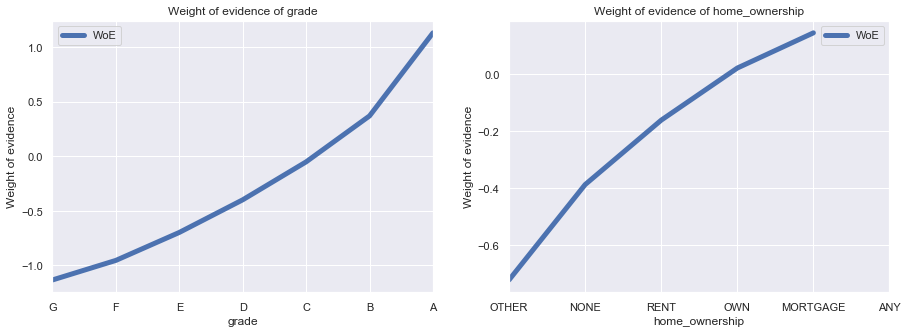

In [21]:
fig,(ax1,ax2) = plt.subplots(1,2)
## calculating woe and plotting for grade
df_temp.plot(ax=ax1,x = 'grade',y='WoE',lw=5,figsize=(15,5))
ax1.set_title('Weight of evidence of grade')
ax1.set_ylabel('Weight of evidence')
## Calculating weight of evidence and plotting for home ownership
df_temp = get_woe_discrete(df_inputs, 'home_ownership', df_targets)
df_temp.set_index('home_ownership')
df_temp.plot(ax = ax2,x = 'home_ownership',y='WoE',lw=5)
ax2.set_title('Weight of evidence of home_ownership')
ax2.set_ylabel('Weight of evidence')

#### From above observation we can conclude that individuals in Grade:G are bad borrowers
Based on weight of evidence we must decide how to organize the catogaries of discrete variables into dummy variables. we will take reference category having the highest default rate.
#### Coarse classing the home_ownership according to Weight of Evidence
Rent,None,other has high default rate hence we keep them as reference category and combine them in one category
We have three category 'home_ownership:RENT_OTHER_NONE' , home_ownership:Own, home_ownership:Mortage

In [22]:
# reference category 'home_ownership:RENT_OTHER_NONE' ,
#other categories'home_ownership:OWN','home_ownership:MORTGAGE'
df_inputs['home_ownership:RENT_OTHER_NONE'] = sum([df_inputs['home_ownership:RENT'], df_inputs['home_ownership:OTHER'],
                                                      df_inputs['home_ownership:NONE']])

#### Addr_state :- Visualising
Now we can see here that there are two states Nebraska and Iowa with a considerably lower weight of evidence compared to most states.There are also two states with a considerably higher weight of evidence Maine and Idaho.Note that weight of evidence for the last state could not be calculated because there are no bad borrowers.Besides it is highly likely that the low number of observations is the reason for their extreme weight of evidence values so we'll include these states in the first the worst and the last the best category

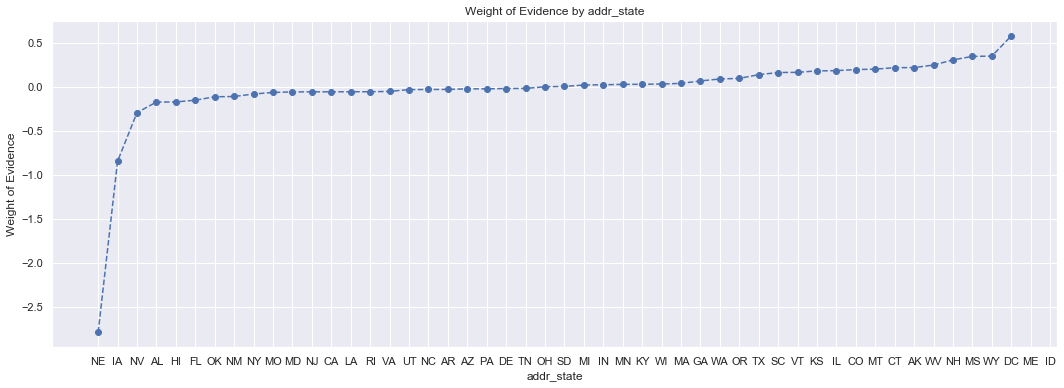

In [23]:
df_temp = get_woe_discrete(df_inputs, 'addr_state', df_targets)
plot_by_woe(df_temp)


Now lets focus on other 46 states: because of the outliers we believed that rest of the state have same weight of evidence .
from  below we will categorise ND,NE,IA,NV,FL,HI,AL together and ME,ID,DC together

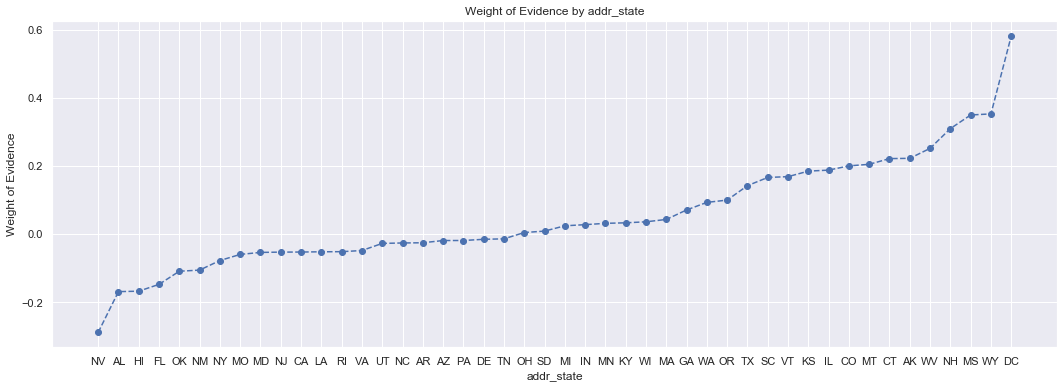

In [24]:
plot_by_woe(df_temp.iloc[2: -2, : ])

In [25]:
#plot_by_woe(df_temp.iloc[4: -3, : ])

In [26]:
#reference category
df_inputs['addr_state:NE_IA_NV_FL_HI_AL'] = sum([df_inputs['addr_state:NE'],
                                              df_inputs['addr_state:IA'], df_inputs['addr_state:NV'],
                                              df_inputs['addr_state:FL'], df_inputs['addr_state:HI'],
                                                          df_inputs['addr_state:AL']])
df_inputs['addr_state:NY_MO_MD_NJ_CA_LA_RI_VA'] = sum([df_inputs['addr_state:NY'], df_inputs['addr_state:MO'],
                                              df_inputs['addr_state:MD'], df_inputs['addr_state:NJ'],
                                              df_inputs['addr_state:CA'], df_inputs['addr_state:LA'],
                                                          df_inputs['addr_state:RI'],df_inputs['addr_state:VA']])
df_inputs['addr_state:UT_NC_AR_AZ_PA_DE_TN_OH_SD'] = sum([df_inputs['addr_state:UT'], df_inputs['addr_state:NC'],
                                              df_inputs['addr_state:AR'], df_inputs['addr_state:AZ'],
                                              df_inputs['addr_state:PA'], df_inputs['addr_state:DE'],
                                              df_inputs['addr_state:TN'],df_inputs['addr_state:OH'],
                                              df_inputs['addr_state:SD']])
df_inputs['addr_state:MI_IN_MN_KY_WI_MA_GA_WA_OR'] = sum([df_inputs['addr_state:MI'], df_inputs['addr_state:IN'],
                                              df_inputs['addr_state:MN'], df_inputs['addr_state:KY'],
                                              df_inputs['addr_state:WI'], df_inputs['addr_state:MA'],
                                              df_inputs['addr_state:GA'],df_inputs['addr_state:WA'],
                                              df_inputs['addr_state:OR']])
df_inputs['addr_state:SC_VT_KS_IL_CO_MT_CT_AK_WV'] = sum([df_inputs['addr_state:SC'], df_inputs['addr_state:VT'],
                                              df_inputs['addr_state:KS'], df_inputs['addr_state:IL'],
                                              df_inputs['addr_state:CO'], df_inputs['addr_state:MT'],
                                              df_inputs['addr_state:CT'],df_inputs['addr_state:AK'],
                                              df_inputs['addr_state:WV']])
df_inputs['addr_state:ME_ID_DC'] = sum([df_inputs['addr_state:ME'], df_inputs['addr_state:ID'],
                                              df_inputs['addr_state:DC']])
df_inputs['addr_state:MS_WY_NH'] = sum([df_inputs['addr_state:MS'], df_inputs['addr_state:WY'],
                                              df_inputs['addr_state:NH']])
# We will leave TX as separate category


#### Verification status : Categorization (Ignored due to very weak predicting power based on Information Value(IV))

In [27]:
df_temp = get_woe_discrete(df_inputs, 'verification_status', df_targets)
df_temp.head(1)

,verification_status,total_obs,prop_good,prop_total_obs,total_good,total_bad,prop_total_good,prop_total_bad,WoE,IV
0,Verified,134563,0.871629,0.360732,117289.0,17274.0,0.353197,0.421832,-0.17758,0.02159


#### Purpose : Categorization (Ignored due to very weak predicting power based on Information Value(IV))

In [28]:
df_temp = get_woe_discrete(df_inputs, 'purpose', df_targets)
df_temp.head(1)

,purpose,total_obs,prop_good,prop_total_obs,total_good,total_bad,prop_total_good,prop_total_bad,WoE,IV
0,small_business,5638,0.780241,0.015114,4399.0,1239.0,0.013247,0.030256,-0.825945,0.037839


#### Preprocessing Continous Variable

In [29]:
# WoE function for continuous variables
def get_woe_continuous(df, continuous_variabe_name, good_bad_variable_df):
    df = pd.concat([df[continuous_variabe_name], good_bad_variable_df], axis = 1)
    df = pd.concat([df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].count(),
                    df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].mean()], axis = 1)
    df = df.iloc[:, [0, 1, 3]]
    df.columns = [df.columns.values[0], 'total_obs', 'prop_good']
    df['prop_total_obs'] = df['total_obs'] / df['total_obs'].sum()
    df['total_good'] = df['prop_good'] * df['total_obs']
    df['total_bad'] = (1 - df['prop_good']) * df['total_obs']
    df['prop_total_good'] = df['total_good'] / df['total_good'].sum()
    df['prop_total_bad'] = df['total_bad'] / df['total_bad'].sum()
    df['WoE'] = np.log(df['prop_total_good'] / df['prop_total_bad'])
    df['IV'] = (df['prop_total_good'] - df['prop_total_bad']) * df['WoE']
    df['IV'] = df['IV'].sum()
    return df

#### Term : Categorization (Ignored due to very weak predicting power based on Information Value(IV))

In [30]:
df_temp = get_woe_continuous(df_inputs, 'term', df_targets)
df_temp.head(1)

,term,total_obs,prop_good,prop_total_obs,total_good,total_bad,prop_total_good,prop_total_bad,WoE,IV
0,36,270204,0.902574,0.724353,243879.0,26325.0,0.734403,0.642857,0.133135,0.0393


#### Emp_length : Categorization (Ignored due to very weak predicting power based on Information Value(IV))

In [31]:
df_temp = get_woe_continuous(df_inputs, 'emp_length', df_targets)
df_temp.head(1)

,emp_length,total_obs,prop_good,prop_total_obs,total_good,total_bad,prop_total_good,prop_total_bad,WoE,IV
0,0.0,45772,0.875251,0.122704,40062.0,5710.0,0.12064,0.139438,-0.144809,0.006642


#### month_since_issue_d: Visualisation/ course classing
There are total 91 distinct value so we can easily treat them as categories.On the other hand it's much neater to work with less than 50 fine class categories when doing course classing.To sum up we'll first define classing of the values of the months since issue date variable.Roughly grouping them into categories then we'll do course classing based on these categories.


In [32]:
df_inputs['month_diff_issue_d'].unique()

array([ 40.,  48.,  67.,  41.,  78.,  64.,  38., 101.,  43.,  36.,  45.,
        65.,  50.,  46.,  83.,  82.,  57.,  49.,  71.,  54.,  42., 122.,
        44.,  68.,  80.,  63.,  37.,  61.,  62.,  52.,  39.,  72.,  51.,
        60.,  86.,  91.,  58.,  94.,  47.,  77.,  56.,  85.,  73.,  76.,
        70.,  93.,  55.,  59.,  79.,  53., 100.,  66.,  92.,  69.,  81.,
        89.,  88.,  87., 116.,  74.,  90.,  75., 110.,  98., 108., 109.,
        95., 104.,  84., 118., 102., 114., 119.,  99.,  97., 106., 107.,
       105., 113.,  96., 103., 115., 125., 117., 111., 121., 112., 124.,
       120., 123., 126.])

In [33]:
#df_temp

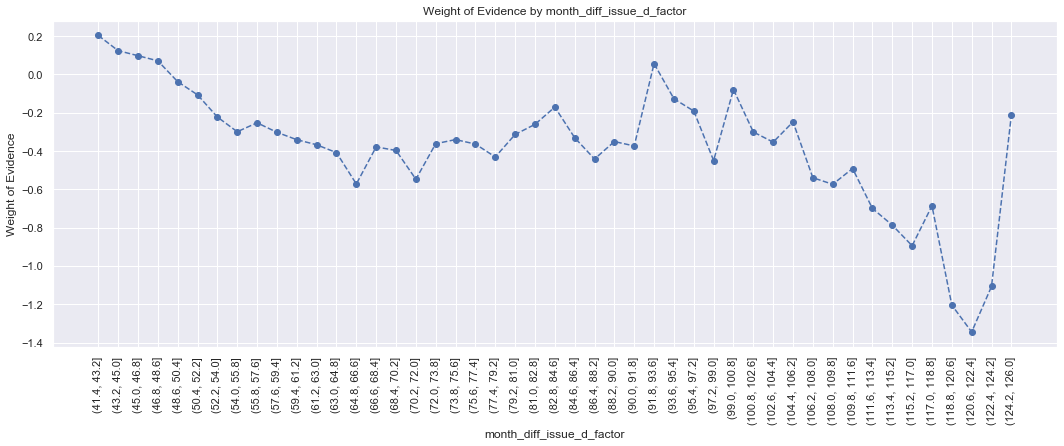

In [34]:
df_inputs['month_diff_issue_d_factor'] = pd.cut(df_inputs['month_diff_issue_d'], 50)
df_temp = get_woe_continuous(df_inputs, 'month_diff_issue_d_factor', df_targets)
plot_by_woe(df_temp.iloc[3: , : ], 90)


From observing df_temp, the value from 97 and greater has very less observation and is therefore a small portion of data. Hence, this is the potential reason for such haphazard graph. So in total we are keeping everything above 65 as one reference category for extra conservative risk management approach.

In [35]:
# We create the following categories:
# < 38, 38 - 41,42 - 50, 51 - 57, 
# reference categor >65.
df_inputs['month_diff_issue_d:<38'] = np.where(df_inputs['month_diff_issue_d'].isin(range(38)), 1, 0)
df_inputs['month_diff_issue_d:38-40'] = np.where(df_inputs['month_diff_issue_d'].isin(range(38, 41)), 1, 0)
df_inputs['month_diff_issue_d:41-42'] = np.where(df_inputs['month_diff_issue_d'].isin(range(41, 43)), 1, 0)
df_inputs['month_diff_issue_d:42-48'] = np.where(df_inputs['month_diff_issue_d'].isin(range(42, 49)), 1, 0)
df_inputs['month_diff_issue_d:49-52'] = np.where(df_inputs['month_diff_issue_d'].isin(range(49, 53)), 1, 0)
df_inputs['month_diff_issue_d:52-65'] = np.where(df_inputs['month_diff_issue_d'].isin(range(53, 65)), 1, 0)
df_inputs['month_diff_issue_d:>65'] = np.where(df_inputs['month_diff_issue_d'].isin(range(65, int(df_inputs['month_diff_issue_d'].max()))), 1, 0)

#### int rate :Visualization
Let us again fine class interest rate variable. we will cut it in 50 categories. From the graph below we can see the greater the interest rate,the lower the weight of evidence.

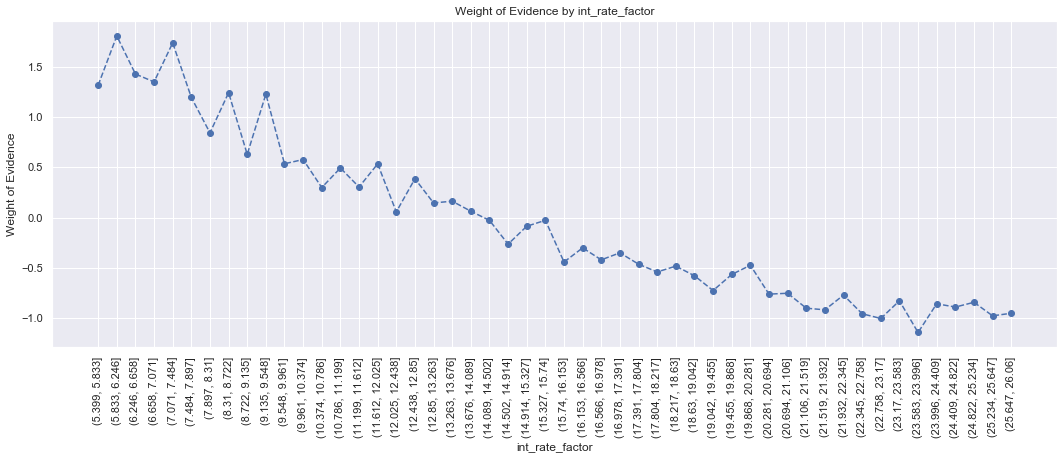

In [36]:
df_inputs['int_rate_factor'] = pd.cut(df_inputs['int_rate'], 50)
df_temp = get_woe_continuous(df_inputs, 'int_rate_factor', df_targets)
plot_by_woe(df_temp, 90)

we put everything less than 9.548 is one bin because it has very less obsservation(5%approx)

In [37]:
# categories , <9.548, '9.548-12.025' ,'12.025-15.74','15.74-20.281',
# reference category >'19.455'
df_inputs['int_rate:<9.548'] = np.where((df_inputs['int_rate'] <= 9.548), 1, 0)
df_inputs['int_rate:9.548-12.025'] = np.where((df_inputs['int_rate'] > 9.548) & (df_inputs['int_rate'] <= 12.025), 1, 0)
df_inputs['int_rate:12.025-15.74'] = np.where((df_inputs['int_rate'] > 12.025) & (df_inputs['int_rate'] <= 15.74), 1, 0)
df_inputs['int_rate:15.74-20.281'] = np.where((df_inputs['int_rate'] > 15.74) & (df_inputs['int_rate'] <= 20.281), 1, 0)
df_inputs['int_rate:>20.281'] = np.where((df_inputs['int_rate'] > 20.281), 1, 0)

#### funded_amnt
From the graph below,it seems that all of these variations are around a trend that is almost horizontal.There is no other clear pattern of dependence between the independent variable and weight of evidence.In other words weight of evidence varies greatly and there seems to be no association whatsoever with the independent variable.This is sufficient reason to make the decision not to use the funded amount variable in our PD model.

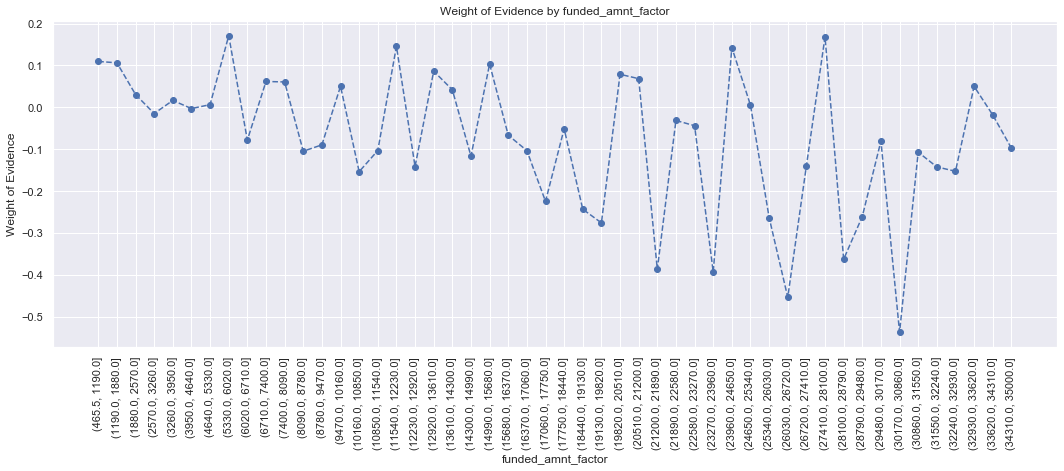

In [38]:
df_inputs['funded_amnt_factor'] = pd.cut(df_inputs['funded_amnt'], 50)
df_temp = get_woe_continuous(df_inputs, 'funded_amnt_factor', df_targets)
plot_by_woe(df_temp, 90)

#### month_diff_earliest_cr_line_factor : Visualisation/categorisation
The first 6 rows is df_temp below does not have any information or observation to calculate weight of evidence.Hence , we will categorze them in single dummy variable.

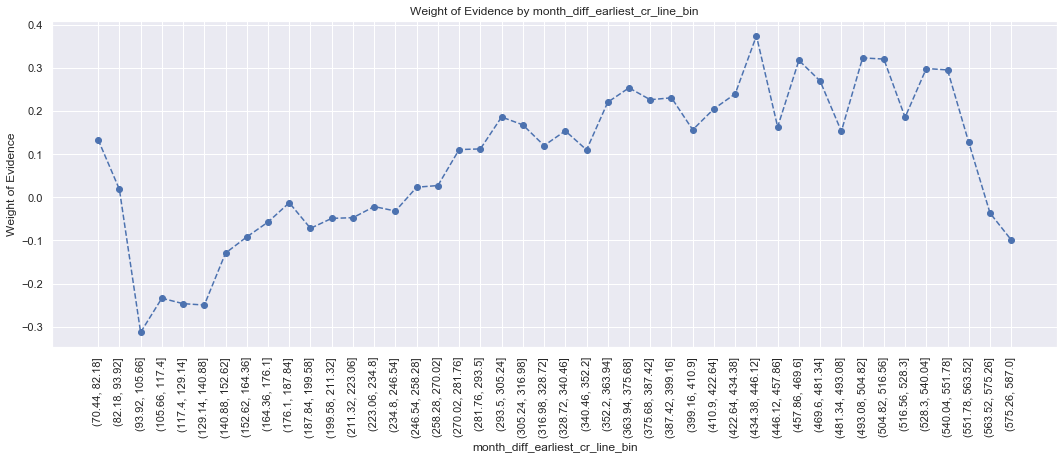

In [39]:
df_inputs['month_diff_earliest_cr_line_bin'] = pd.cut(df_inputs['month_diff_earliest_cr_line'], 50)
df_temp = get_woe_continuous(df_inputs, 'month_diff_earliest_cr_line_bin', df_targets)
plot_by_woe(df_temp.iloc[6: , : ], 90)

In [40]:
df_inputs['month_diff_earliest_cr_line:<141'] = np.where(df_inputs['month_diff_earliest_cr_line'].isin(range(141)), 1, 0)
df_inputs['month_diff_earliest_cr_line:142-247'] = np.where(df_inputs['month_diff_earliest_cr_line'].isin(range(140, 248)), 1, 0)
df_inputs['month_diff_earliest_cr_line:248-271'] = np.where(df_inputs['month_diff_earliest_cr_line'].isin(range(248, 272)), 1, 0)
df_inputs['month_diff_earliest_cr_line:272-353'] = np.where(df_inputs['month_diff_earliest_cr_line'].isin(range(272, 354)), 1, 0)
df_inputs['month_diff_earliest_cr_line:>353'] = np.where(df_inputs['month_diff_earliest_cr_line'].isin(range(354, int(df_inputs['month_diff_earliest_cr_line'].max()))), 1, 0)

#### delinq_2yrs : Visualisation/categorisation

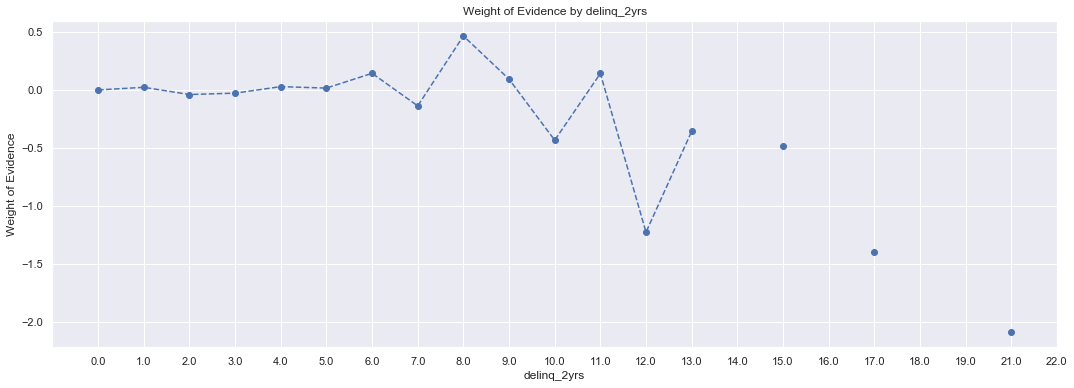

In [41]:
df_temp = get_woe_continuous(df_inputs, 'delinq_2yrs', df_targets)
plot_by_woe(df_temp)

 We see that number of observations are very low for delinq>=2, we will place them under one bin.So, we have following groups : 0, 1-2, >2

In [42]:
# Categories: 0, 1-2, >=2
df_inputs['delinq_2yrs:0'] = np.where((df_inputs['delinq_2yrs'] == 0), 1, 0)
df_inputs['delinq_2yrs:1-2'] = np.where((df_inputs['delinq_2yrs'] >= 1) & (df_inputs['delinq_2yrs'] < 2), 1, 0)
df_inputs['delinq_2yrs:>=2'] = np.where((df_inputs['delinq_2yrs'] >= 2), 1, 0)

#### inq_last_6mths : Visualisation/categorisation

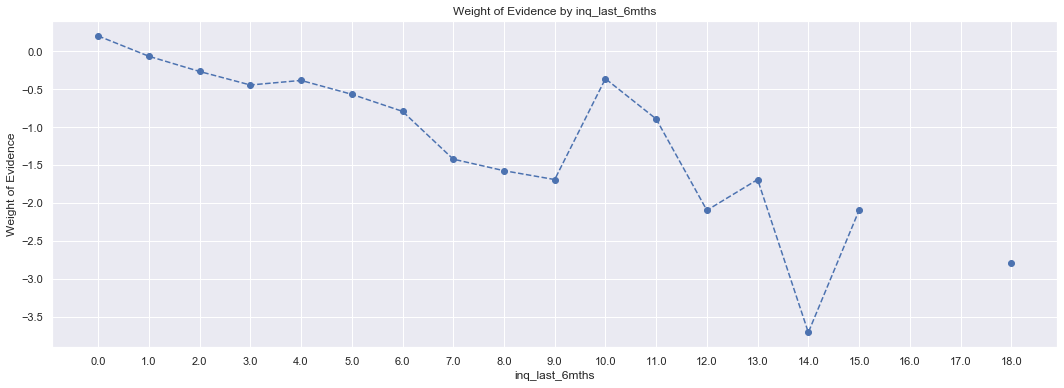

In [43]:
df_temp = get_woe_continuous(df_inputs, 'inq_last_6mths', df_targets)
plot_by_woe(df_temp)

In [44]:
# Categories: 0, 1, 2, 3, > 3
df_inputs['inq_last_6mths:0'] = np.where((df_inputs['inq_last_6mths'] == 0), 1, 0)
df_inputs['inq_last_6mths:1'] = np.where((df_inputs['inq_last_6mths'] == 1), 1, 0)
df_inputs['inq_last_6mths:2'] = np.where((df_inputs['inq_last_6mths'] == 2), 1, 0)
df_inputs['inq_last_6mths:3'] = np.where((df_inputs['inq_last_6mths'] == 3), 1, 0)
df_inputs['inq_last_6mths:>3'] = np.where((df_inputs['inq_last_6mths'] > 3), 1, 0)

#### open_acc:Visualisation/categorisation

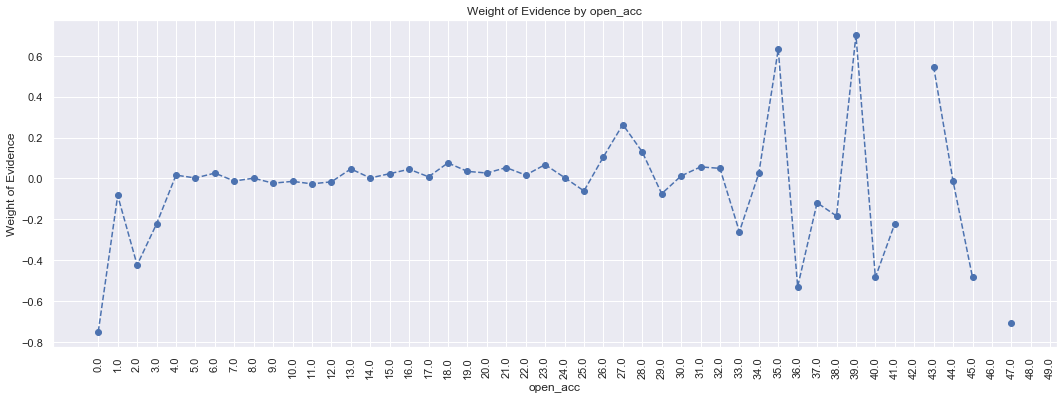

In [45]:
df_temp = get_woe_continuous(df_inputs, 'open_acc', df_targets)
plot_by_woe(df_temp, 90)

In [46]:
# Categories: '0-3','4-12', '13-17', '18-24', '>25'
df_inputs['open_acc:0-3'] = np.where((df_inputs['open_acc'] >= 0) & (df_inputs['open_acc'] <= 3), 1, 0)
df_inputs['open_acc:4-12'] = np.where((df_inputs['open_acc'] >= 4) & (df_inputs['open_acc'] <= 12), 1, 0)
df_inputs['open_acc:13-17'] = np.where((df_inputs['open_acc'] >= 13) & (df_inputs['open_acc'] <= 17), 1, 0)
df_inputs['open_acc:18-24'] = np.where((df_inputs['open_acc'] >= 18) & (df_inputs['open_acc'] <= 24), 1, 0)
df_inputs['open_acc:>=25'] = np.where((df_inputs['open_acc'] >= 25), 1, 0)

#### pub_rec : Visualisation/categorisation

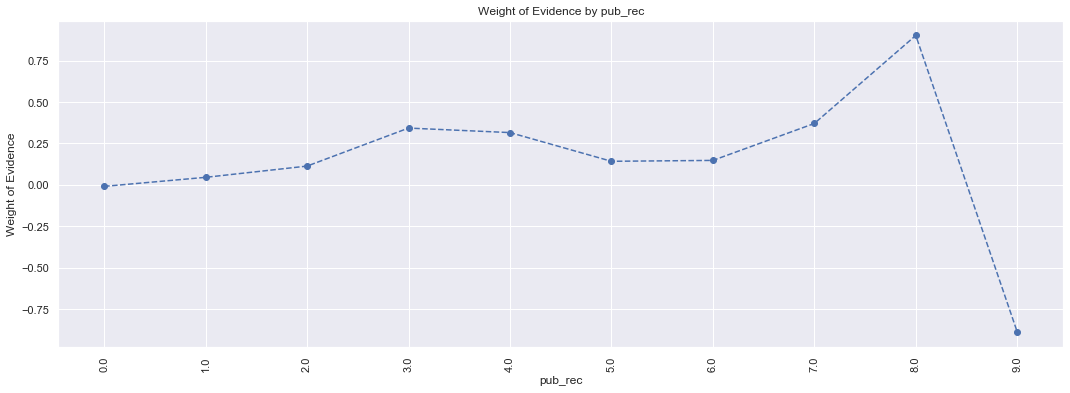

In [47]:
df_temp = get_woe_continuous(df_inputs, 'pub_rec', df_targets)
plot_by_woe(df_temp, 90)

In [48]:
# Categories '0', '1', '>=2'
df_inputs['pub_rec:0'] = np.where((df_inputs['pub_rec'] == 0), 1, 0)
df_inputs['pub_rec:1'] = np.where((df_inputs['pub_rec'] == 1), 1, 0)
df_inputs['pub_rec:>=2'] = np.where((df_inputs['pub_rec'] >= 2), 1, 0)

#### total_acc_factor : Visualisation/categorisation

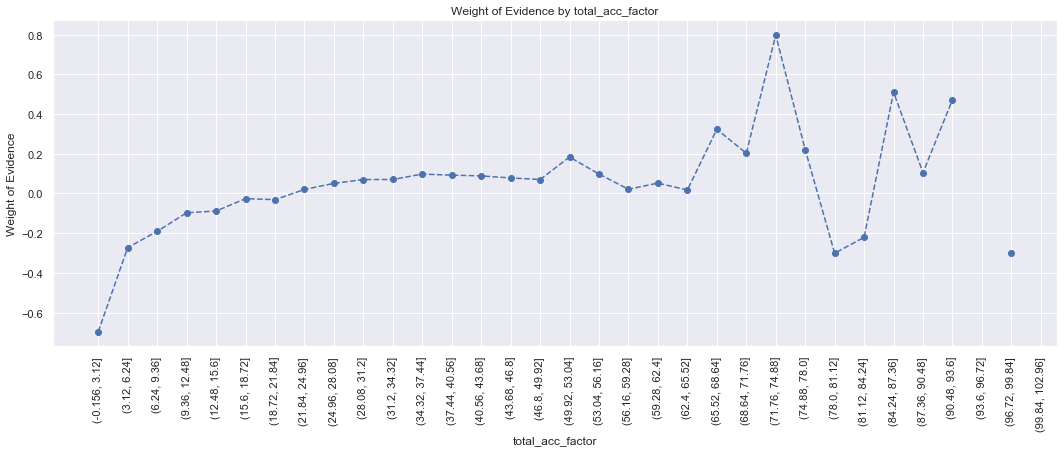

In [49]:

df_inputs['total_acc_factor'] = pd.cut(df_inputs['total_acc'], 50)
df_temp = get_woe_continuous(df_inputs, 'total_acc_factor', df_targets)
plot_by_woe(df_temp, 90)

In [50]:
# Categories: '<=10','11-16', '17-22','23-50', '>51'
df_inputs['total_acc:<=10'] = np.where((df_inputs['total_acc'] <= 10), 1, 0)
df_inputs['total_acc:11-16'] = np.where((df_inputs['total_acc'] >= 11) & (df_inputs['total_acc'] <= 16), 1, 0)
df_inputs['total_acc:17-22'] = np.where((df_inputs['total_acc'] >= 17) & (df_inputs['total_acc'] <= 22), 1, 0)
df_inputs['total_acc:23-50'] = np.where((df_inputs['total_acc'] >= 23) & (df_inputs['total_acc'] <= 50), 1, 0)
df_inputs['total_acc:>=51'] = np.where((df_inputs['total_acc'] >= 51), 1, 0)

#### acc_now_delinq : Visualisation/categorisation

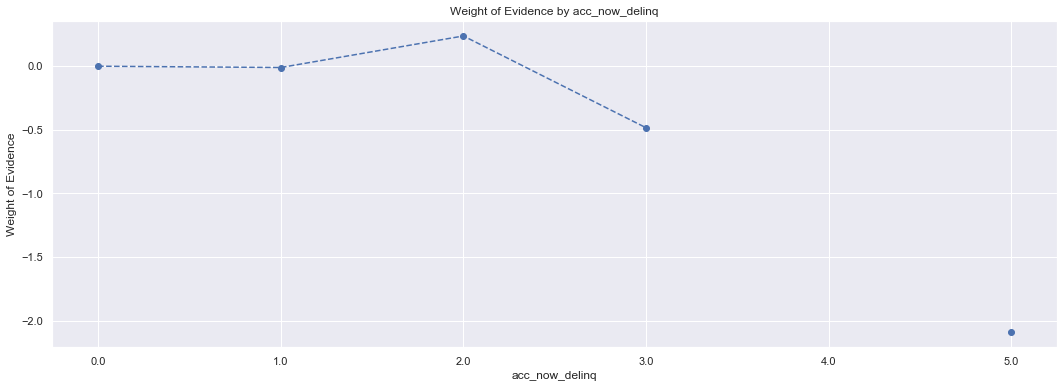

In [51]:
df_temp = get_woe_continuous(df_inputs, 'acc_now_delinq', df_targets)
plot_by_woe(df_temp)

In [52]:
# Categories: '0', '>=1'
df_inputs['acc_now_delinq:0'] = np.where((df_inputs['acc_now_delinq'] == 0), 1, 0)
df_inputs['acc_now_delinq:>=1'] = np.where((df_inputs['acc_now_delinq'] >= 1), 1, 0)

#### total_rev_hi_lim : Visualisation/categorisation

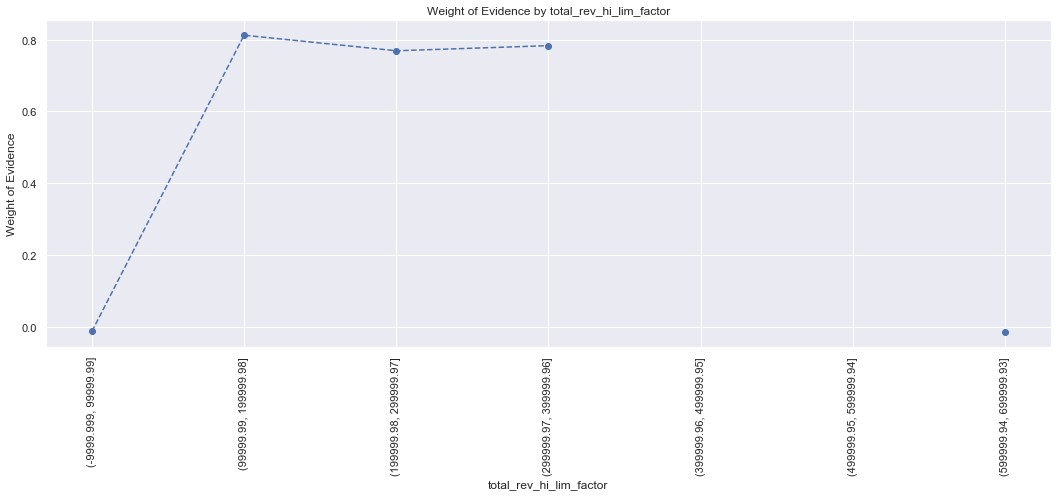

In [53]:
df_inputs['total_rev_hi_lim_factor'] = pd.cut(df_inputs['total_rev_hi_lim'], 100)
df_temp = get_woe_continuous(df_inputs, 'total_rev_hi_lim_factor', df_targets)
plot_by_woe(df_temp, 90)

In [54]:
# Categories
# '<=10K', '10K-20K', '20K-30K', '30K-40K', '40K-50K', '50K-60K', '60K-100K', '>100K'
df_inputs['total_rev_hi_lim:<=10K'] = np.where((df_inputs['total_rev_hi_lim'] <= 10000), 1, 0)
df_inputs['total_rev_hi_lim:10K-20K'] = np.where((df_inputs['total_rev_hi_lim'] > 10000) & (df_inputs['total_rev_hi_lim'] <= 20000), 1, 0)
df_inputs['total_rev_hi_lim:20K-30K'] = np.where((df_inputs['total_rev_hi_lim'] > 20000) & (df_inputs['total_rev_hi_lim'] <= 30000), 1, 0)
df_inputs['total_rev_hi_lim:30K-40K'] = np.where((df_inputs['total_rev_hi_lim'] > 30000) & (df_inputs['total_rev_hi_lim'] <= 40000), 1, 0)
df_inputs['total_rev_hi_lim:40K-50K'] = np.where((df_inputs['total_rev_hi_lim'] > 40000) & (df_inputs['total_rev_hi_lim'] <= 50000), 1, 0)
df_inputs['total_rev_hi_lim:50K-60K'] = np.where((df_inputs['total_rev_hi_lim'] > 50000) & (df_inputs['total_rev_hi_lim'] <= 60000), 1, 0)
df_inputs['total_rev_hi_lim:60K-100K'] = np.where((df_inputs['total_rev_hi_lim'] > 60000) & (df_inputs['total_rev_hi_lim'] <= 100000), 1, 0)
df_inputs['total_rev_hi_lim:>100K'] = np.where((df_inputs['total_rev_hi_lim'] > 100000), 1, 0)

#### installment : Categorization (Ignored due to very weak predicting power based on Information Value(IV))

In [55]:
df_inputs['installment_factor'] = pd.cut(df_inputs['installment'], 50)
df_temp = get_woe_continuous(df_inputs, 'installment_factor', df_targets)
df_temp.head(1)

,installment_factor,total_obs,prop_good,prop_total_obs,total_good,total_bad,prop_total_good,prop_total_bad,WoE,IV
0,"(14.356, 43.635]",1869,0.896201,0.00501,1675.0,194.0,0.005044,0.004737,0.062692,0.013093


#### annual_inc : Visualisation/categorisation

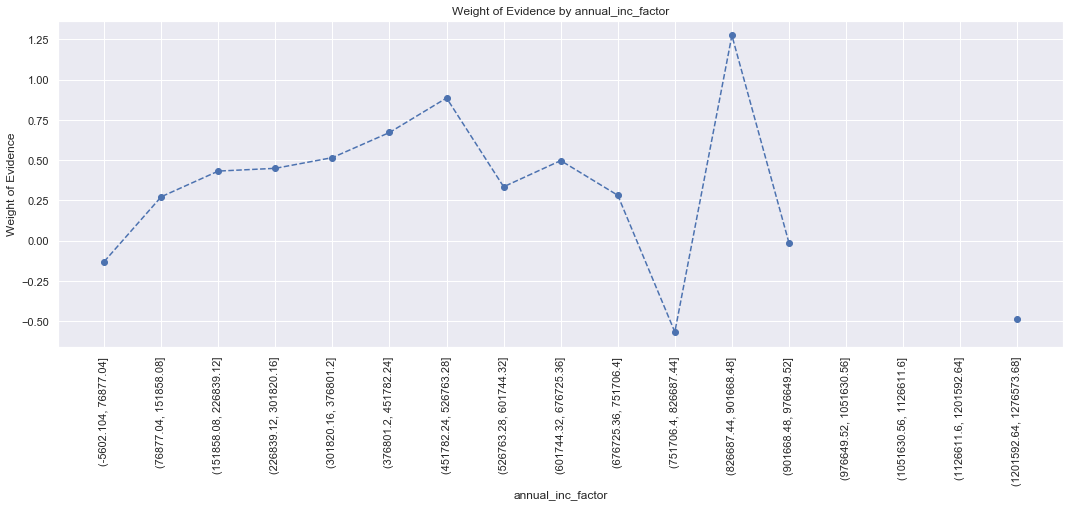

In [56]:
df_inputs['annual_inc_factor'] = pd.cut(df_inputs['annual_inc'], 100)
df_temp = get_woe_continuous(df_inputs, 'annual_inc_factor', df_targets)
plot_by_woe(df_temp, 90)

In [57]:
df_inputs['annual_inc:<77K'] = np.where((df_inputs['annual_inc'] <= 77000), 1, 0)
df_inputs['annual_inc:77K-152K'] = np.where((df_inputs['annual_inc'] > 77000) & (df_inputs['annual_inc'] <= 152000), 1, 0)
df_inputs['annual_inc:>152K'] = np.where((df_inputs['annual_inc'] > 152000), 1, 0)

#### mths_since_last_delinq : Visualisation/categorisation

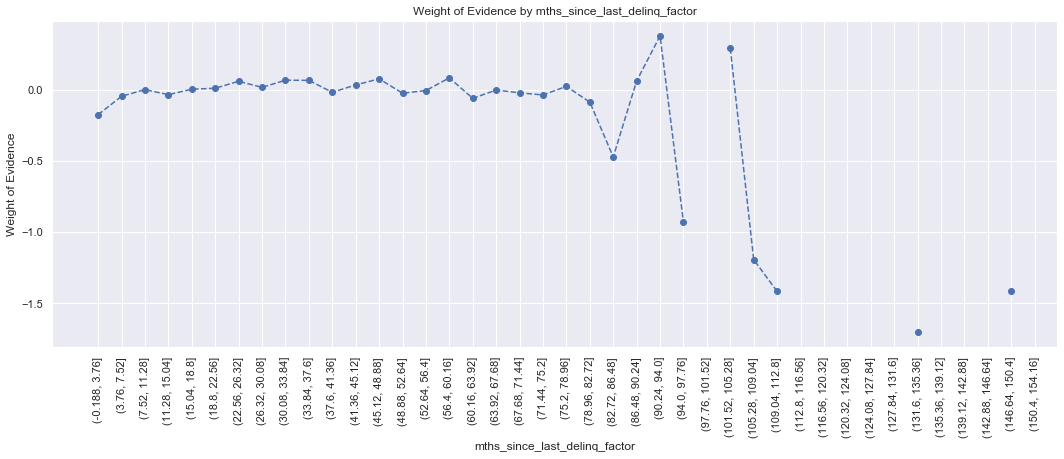

In [58]:
df_inputs_temp = df_inputs[pd.notnull(df_inputs['mths_since_last_delinq'])]
df_inputs_temp['mths_since_last_delinq_factor'] = pd.cut(df_inputs_temp['mths_since_last_delinq'], 50)
df_temp = get_woe_continuous(df_inputs_temp, 'mths_since_last_delinq_factor', df_targets)
plot_by_woe(df_temp,90)

#### mths_since_last_delinq : Visualisation/categorisation

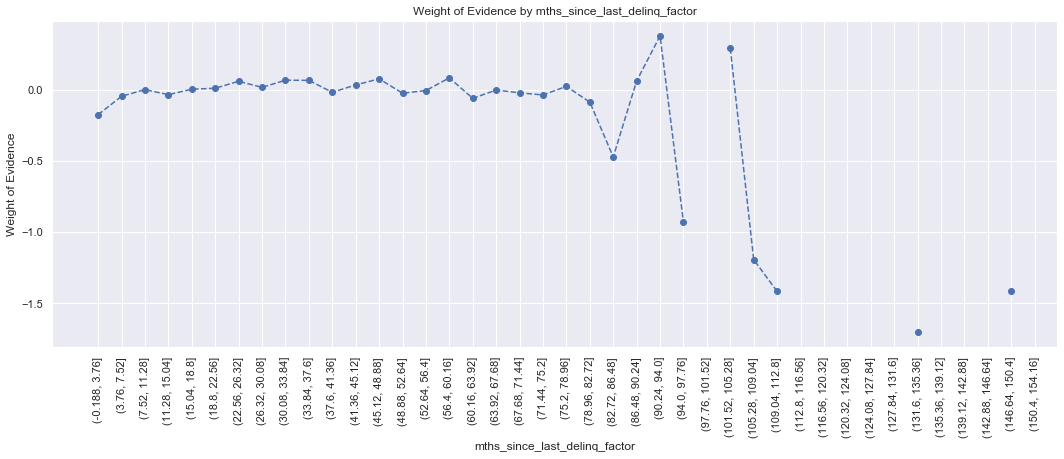

In [59]:
df_inputs_temp = df_inputs[pd.notnull(df_inputs['mths_since_last_delinq'])]
df_inputs_temp['mths_since_last_delinq_factor'] = pd.cut(df_inputs_temp['mths_since_last_delinq'], 50)
df_temp = get_woe_continuous(df_inputs_temp, 'mths_since_last_delinq_factor', df_targets)
plot_by_woe(df_temp, 90)

In [60]:
df_inputs['mths_since_last_delinq:Null'] = np.where((df_inputs['mths_since_last_delinq'].isnull()), 1, 0)
df_inputs['mths_since_last_delinq:0-4'] = np.where((df_inputs['mths_since_last_delinq'] >= 0) & (df_inputs['mths_since_last_delinq'] <= 4), 1, 0)
df_inputs['mths_since_last_delinq:4-8'] = np.where((df_inputs['mths_since_last_delinq'] > 4) & (df_inputs['mths_since_last_delinq'] <= 8), 1, 0)
df_inputs['mths_since_last_delinq:8-80'] = np.where((df_inputs['mths_since_last_delinq'] > 8) & (df_inputs['mths_since_last_delinq'] <= 80), 1, 0)
df_inputs['mths_since_last_delinq:>=80'] = np.where((df_inputs['mths_since_last_delinq'] > 80), 1, 0)

#### dti : Visualisation/categorisation

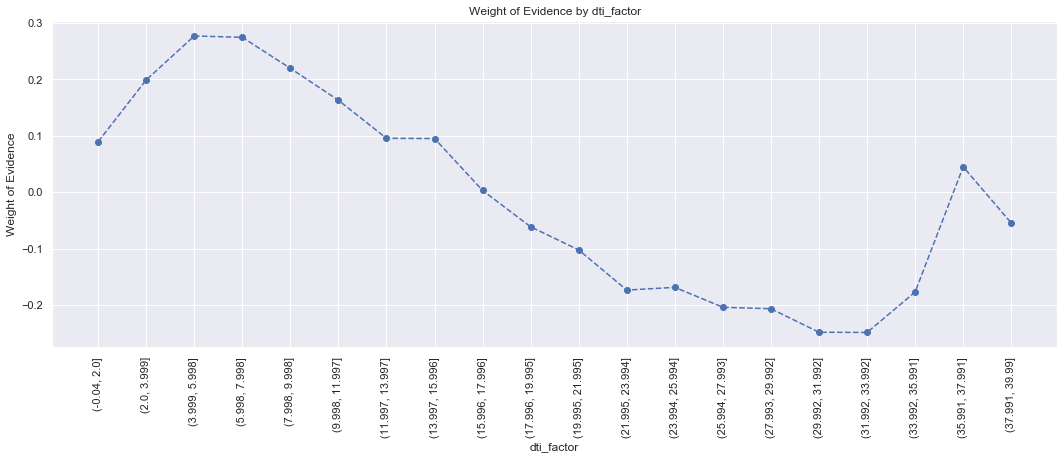

In [61]:
df_inputs['dti_factor'] = pd.cut(df_inputs['dti'], 20)
df_temp = get_woe_continuous(df_inputs, 'dti_factor', df_targets)
plot_by_woe(df_temp,90)

In [62]:
# Categories:
df_inputs['dti:<=4'] = np.where((df_inputs['dti'] <= 1.4), 1, 0)
df_inputs['dti:1.4-3.5'] = np.where((df_inputs['dti'] > 1.4) & (df_inputs['dti'] <= 3.5), 1, 0)
df_inputs['dti:3.5-7.7'] = np.where((df_inputs['dti'] > 3.5) & (df_inputs['dti'] <= 7.7), 1, 0)
df_inputs['dti:7.7-10.5'] = np.where((df_inputs['dti'] > 7.7) & (df_inputs['dti'] <= 10.5), 1, 0)
df_inputs['dti:10.5-16.1'] = np.where((df_inputs['dti'] > 10.5) & (df_inputs['dti'] <= 16.1), 1, 0)
df_inputs['dti:16.1-20.3'] = np.where((df_inputs['dti'] > 16.1) & (df_inputs['dti'] <= 20.3), 1, 0)
df_inputs['dti:20.3-21.7'] = np.where((df_inputs['dti'] > 20.3) & (df_inputs['dti'] <= 21.7), 1, 0)
df_inputs['dti:21.7-22.4'] = np.where((df_inputs['dti'] > 21.7) & (df_inputs['dti'] <= 22.4), 1, 0)
df_inputs['dti:22.4-35'] = np.where((df_inputs['dti'] > 22.4) & (df_inputs['dti'] <= 35), 1, 0)
df_inputs['dti:>35'] = np.where((df_inputs['dti'] > 35), 1, 0)

As we can se below the loan amount plot has lot of ups and down. Therefore, it is not a reliable variable for prediction

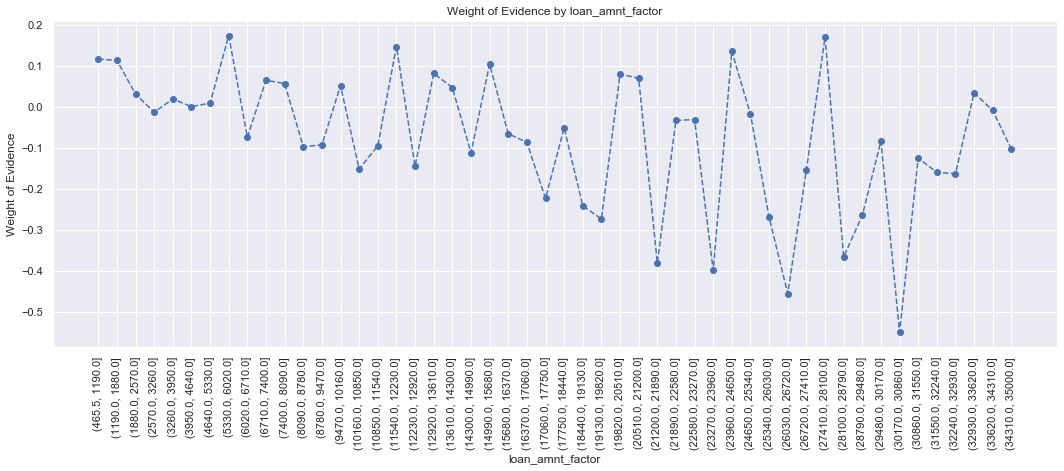

In [63]:
df_inputs['loan_amnt_factor'] = pd.cut(df_inputs['loan_amnt'], 50)
df_temp = get_woe_continuous(df_inputs, 'loan_amnt_factor', df_targets)
df_temp
plot_by_woe(df_temp,90)


### Preparing Test Dataset
### <font color='green'>Note: we need to re run the entire data processing step for test data after Train test split.</font> 
In order to test the model in the test set, we must have the same dummy variable as the one in the train set. Thus we will data processing code for test data

### SELECTING THE FEATURES FOR MODEL BUILDING

In [64]:
# Categories which we categorised using WOE
dummy_cols = ['grade:A','grade:B','grade:C','grade:D','grade:E','grade:F','grade:G','home_ownership:RENT_OTHER_NONE','home_ownership:OWN','home_ownership:MORTGAGE','addr_state:NE_IA_NV_FL_HI_AL','addr_state:NY_MO_MD_NJ_CA_LA_RI_VA','addr_state:UT_NC_AR_AZ_PA_DE_TN_OH_SD','addr_state:MI_IN_MN_KY_WI_MA_GA_WA_OR','addr_state:SC_VT_KS_IL_CO_MT_CT_AK_WV','addr_state:ME_ID_DC','addr_state:MS_WY_NH','addr_state:TX','month_diff_issue_d:<38','month_diff_issue_d:38-40','month_diff_issue_d:41-42','month_diff_issue_d:42-48','month_diff_issue_d:49-52','month_diff_issue_d:52-65','month_diff_issue_d:>65','int_rate:<9.548','int_rate:9.548-12.025','int_rate:12.025-15.74','int_rate:15.74-20.281','int_rate:>20.281','month_diff_earliest_cr_line:<141','month_diff_earliest_cr_line:142-247','month_diff_earliest_cr_line:248-271','month_diff_earliest_cr_line:272-353','month_diff_earliest_cr_line:>353','delinq_2yrs:0','delinq_2yrs:>=2','delinq_2yrs:1-2','inq_last_6mths:0','inq_last_6mths:1','inq_last_6mths:2','inq_last_6mths:3','inq_last_6mths:>3','open_acc:0-3','open_acc:4-12','open_acc:13-17','open_acc:18-24','open_acc:>=25','pub_rec:0','pub_rec:1','pub_rec:>=2','total_acc:<=10','total_acc:11-16','total_acc:17-22','total_acc:23-50','total_acc:>=51','acc_now_delinq:0','acc_now_delinq:>=1','total_rev_hi_lim:<=10K','total_rev_hi_lim:10K-20K','total_rev_hi_lim:20K-30K','total_rev_hi_lim:30K-40K','total_rev_hi_lim:40K-50K','total_rev_hi_lim:50K-60K','total_rev_hi_lim:60K-100K','total_rev_hi_lim:>100K','annual_inc:<77K','annual_inc:77K-152K','annual_inc:>152K','mths_since_last_delinq:Null','mths_since_last_delinq:0-4','mths_since_last_delinq:4-8','mths_since_last_delinq:8-80','mths_since_last_delinq:>=80','dti:<=4','dti:1.4-3.5','dti:3.5-7.7','dti:7.7-10.5','dti:10.5-16.1','dti:16.1-20.3','dti:20.3-21.7','dti:21.7-22.4','dti:22.4-35','dti:>35'
]
#Reference category
ref_cols = ['grade:G','home_ownership:RENT_OTHER_NONE','addr_state:NE_IA_NV_FL_HI_AL','verification_status:Verified','purpose:educ_small_other_moving_ren_house','term:60','emp_length:0','month_diff_issue_d:>65','int_rate:>20.281','mths_since_earliest_cr_line:<141','delinq_2yrs:>=2','inq_last_6mths:>3','open_acc:>=25','pub_rec:0','total_acc:<=10','acc_now_delinq:>=1','total_rev_hi_lim:>100K','installment:>=211','annual_inc:<64K','mths_since_last_delinq:0-4','dti:>35']

Below we will subtract ref_cols from dummy_cols in order to avoid dummy Traps. Dummy Traps is a scenario in which the independent variables are multicollinear; - a scenario in which two or more variables are highly correlated; in simple terms one variable can be predicted from the others. Please refer to the link in reference to know more about Dummy Traps.

In [65]:
input_cols = list(filter(lambda x: (x not in ref_cols), dummy_cols))

In [66]:
X_train = df_inputs.loc[:, input_cols]
# X_test = df_inputs.loc[:, input_cols]
Y_train = loan_data_targets_train
# Y_test = loan_data_targets_test

In [67]:
X_train.to_csv('X_train.csv', index = False)
# X_test.to_csv('X_test.csv', index = False)
Y_train.to_csv('Y_train.csv', index = False)
# Y_test.to_csv('Y_test.csv', index = False)

In [68]:
import numpy as np
import pandas as pd
X_train = pd.read_csv('X_train.csv')
X_test = pd.read_csv('X_test.csv')
Y_train = pd.read_csv('Y_train.csv')
Y_test = pd.read_csv('Y_test.csv')

In [69]:
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(373028, 70)
(373028, 1)
(93257, 70)
(93257, 1)


## Model Training and Testing

#### We will use three classification models namely - Logistic Regression, Naive Bayes and Decision Tree model.

### Logistic Regression

In [119]:
from sklearn.linear_model import LogisticRegression

In [120]:
logit_model = LogisticRegression(solver = 'lbfgs', max_iter=1000)
logit_model.fit(X_train,Y_train['good_bad'].values)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [121]:
logit_model.score(X_test.values, Y_test['good_bad'].values)

0.8925549824678041

##### Cross Validation Score of Logistic regression model.

In [122]:
cv_score_list = []
from sklearn.model_selection import cross_val_score
cv_score = cross_val_score(LogisticRegression(solver = 'lbfgs', max_iter=1000),X_train.values,Y_train['good_bad'].values,cv=5).mean()
cv_score_list.append(cv_score)
print(str(cv_score))

0.8902119948268666


### Gaussian Naive Bayes

In [123]:
from sklearn.naive_bayes import GaussianNB

In [124]:
skl_gnb = GaussianNB().fit(X_train.values,Y_train['good_bad'].values)

In [125]:
skl_gnb.score(X_test.values, Y_test['good_bad'].values)

0.672164019859099

##### Cross Validation Score of Naive Bayes

In [126]:
cv_score = cross_val_score(GaussianNB(),X_train.values,Y_train['good_bad'].values,cv=5).mean()
cv_score_list.append(cv_score)
print(str(cv_score))

0.6774102936107415


### DecisionTree Classifier

In [127]:
from sklearn.tree import DecisionTreeClassifier

In [128]:
max_depths = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, None]
max_features = [1,2,3,4,5,6,'auto','log2'] 

In [129]:
scores_dt = pd.DataFrame(index=np.arange(len(max_depths)), columns=np.arange(len(max_features)))
for i in range(0,len(max_depths)):
    for j in range(0,len(max_features)):
        scores_dt.iloc[i,j] = cross_val_score(DecisionTreeClassifier(max_depth=max_depths[i], max_features = max_features[j]),
                                           X_train.values,Y_train['good_bad'].values,cv=5).mean()

##### Fine tuning max_depth and max_features parameters for the decision tree model.

,1,2,3,4,5,6,auto,log2
max_depth,,,,,,,,
1.0,0.890223,0.890223,0.890223,0.890223,0.890223,0.890223,0.890223,0.890223
2.0,0.890223,0.890223,0.890223,0.890223,0.890223,0.890223,0.890223,0.890223
3.0,0.890223,0.890223,0.890223,0.890223,0.890223,0.890223,0.890223,0.890223
4.0,0.890223,0.890223,0.89022,0.890228,0.890223,0.890223,0.890223,0.890217
5.0,0.890223,0.890225,0.890209,0.890223,0.89022,0.890223,0.89022,0.89022
6.0,0.890207,0.890217,0.890217,0.890207,0.890193,0.89022,0.890207,0.890209
7.0,0.890207,0.890209,0.890191,0.890207,0.890209,0.890177,0.890164,0.890204
8.0,0.890185,0.890174,0.890115,0.890169,0.890207,0.890188,0.890164,0.890124
9.0,0.890129,0.890124,0.890081,0.89004,0.890016,0.890014,0.889933,0.890065


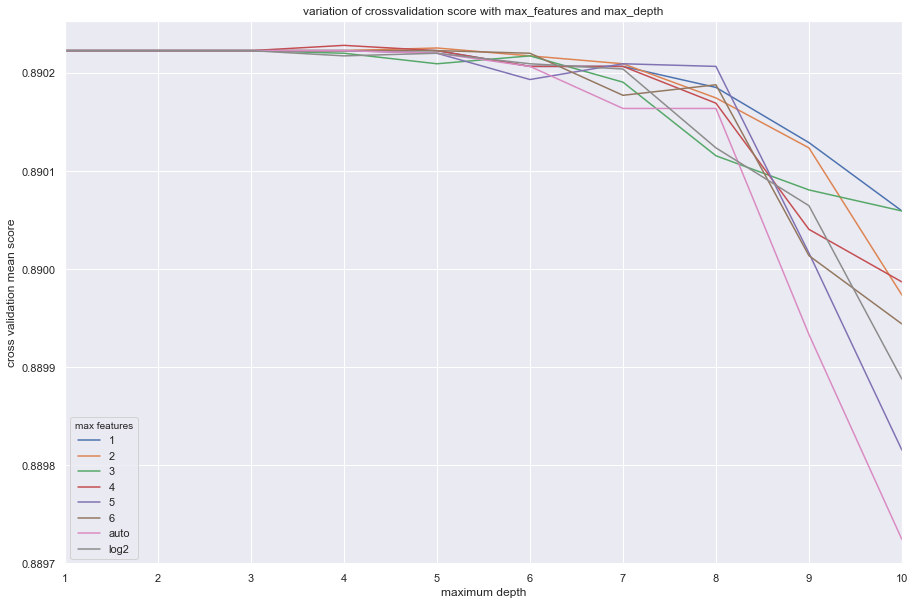

In [130]:
scores_dt['max_depth'] = max_depths
scores_dt.set_index('max_depth', inplace = True)
scores_dt.rename(columns={0:"1", 1: "2",2:"3",3:"4",4:"5",5:"6",6:"auto",7:"log2"}, inplace = True)
ax = scores_dt.plot(figsize = (15,10))
ax.set_xticklabels([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, None])
ax.set_xlabel("maximum depth")
ax.set_ylabel("cross validation mean score")
ax.set_title("variation of crossvalidation score with max_features and max_depth")
ax.legend(max_features, title = "max features")
scores_dt.max()
scores_dt

In [131]:
scores_dt.reset_index('max_depth', inplace = True)
scores_dt = scores_dt.apply(pd.to_numeric)
scores_dt.max()

max_depth    10.000000
1             0.890223
2             0.890225
3             0.890223
4             0.890228
5             0.890223
6             0.890223
auto          0.890223
log2          0.890223
dtype: float64

In [132]:
# We found the most optimal parameter setting is at max_depth = 4 and max_features = 4
skl_dt = DecisionTreeClassifier(max_depth=4, max_features = 4).fit(X_train.values,Y_train['good_bad'].values)

In [133]:
skl_dt.score(X_test.values, Y_test['good_bad'].values)

0.8925764285790879

##### Cross Validation score of Decision Tree Model

In [136]:
cv_score = cross_val_score(DecisionTreeClassifier(max_depth=4, max_features = 4),X_train.values,Y_train['good_bad'].values,cv=5).mean()
cv_score_list.append(cv_score)
print(str(cv_score))

0.8902227178609495


## AUC Scores of all models 

#### Logistic Regression Model 

In [137]:
from sklearn.metrics import roc_curve, auc

In [138]:
auc_score_list = []
tpr_list = []
fpr, tpr, thresholds = roc_curve(Y_test['good_bad'].values, logit_model.predict_proba(X_test.values)[:, 1]) 
auc_score = auc(fpr, tpr)
auc_score_list.append(auc_score)
print("AUC Score for the Logistic Regression Model : " + str(auc_score))

AUC Score for the Logistic Regression Model : 0.6857705338094551


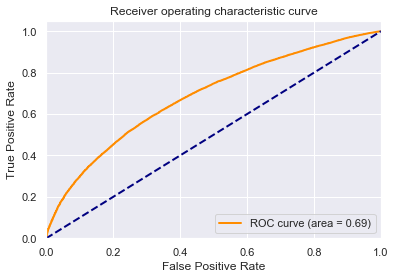

In [139]:
def PlotROC(fpr, tpr, auc_score):
    import matplotlib.pyplot as plt
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % auc_score)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic curve')
    plt.legend(loc="lower right")
    plt.show()
    
PlotROC(fpr,tpr, auc_score)

#### Naive Bayes

In [140]:
fpr, tpr, thresholds = roc_curve(Y_test['good_bad'].values, skl_gnb.predict_proba(X_test.values)[:, 1]) 
auc_score = auc(fpr, tpr)
auc_score_list.append(auc_score)
print("AUC Score for the Naive Bayes Model : " + str(auc_score))

AUC Score for the Naive Bayes Model : 0.6584276991092748


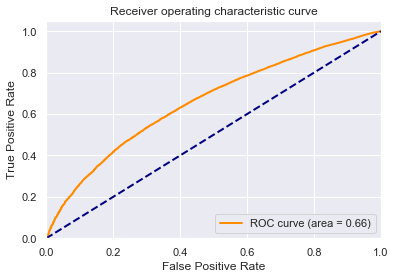

In [141]:
PlotROC(fpr,tpr, auc_score)

#### Decision Tree

In [142]:
fpr, tpr, thresholds = roc_curve(Y_test['good_bad'].values, skl_dt.predict_proba(X_test.values)[:, 1]) 
auc_score = auc(fpr, tpr)
auc_score_list.append(auc_score)
print("AUC Score for the Decision Tree Model : " + str(auc_score))


AUC Score for the Decision Tree Model : 0.6239548675189354


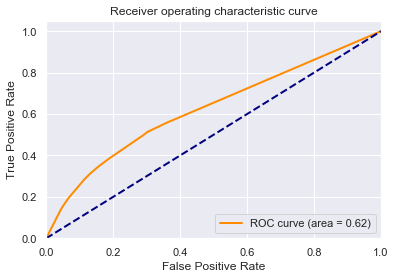

In [143]:
PlotROC(fpr,tpr, auc_score)

### Model Comparison

In [144]:
models = ['Logistic Regression', 'Naive Bayes', 'Decision Tree']
d = {'Model': models , 'CV Score': cv_score_list, 'AUC Score' : auc_score_list} 
df = pd.DataFrame(data=d)
print(df)     

                 Model  CV Score  AUC Score
0  Logistic Regression  0.890212   0.685771
1          Naive Bayes  0.677410   0.658428
2        Decision Tree  0.890223   0.623955


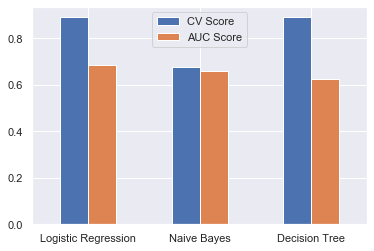

In [145]:
df = pd.DataFrame({'CV Score': cv_score_list,
                   'AUC Score': auc_score_list}, index=models)
ax = df.plot.bar(rot=0)

## Conclusion

#### A true positive in credit risk assessment is a measure of how many creditworthy applicants are correctly identified as creditworthy. Whereas, true negative is a measure of how many uncreditworthy applications are identified as uncreditworthy. A good model will result in a high number of true positives and true negatives. The higher the AUC, the better the model is at assessing creditworthiness. We note that, compared to other models,  logistic regression has the highest AUC score as well as the highest CV Score. We also note that Naive Bayes model performed the worst since it has the lowest CV score. Though Decision tree has CV score similar to logistic regression model, it does not perform well when we consider the AUC score. Hence, we can conclude that logistic regression is the best model amongst all three models for predicting creditworthiness of a borrower.

## References

https://www.listendata.com/2015/03/weight-of-evidence-woe-and-information.html
https://medium.com/datadriveninvestor/dummy-variable-trap-c6d4a387f10a
